# ETF Pipeline2 using s3

> Gradually bringing in over stuff from first pipeline. ETF flow decompositions pipeline but querying data from arcticdb.
- skip_exec: true

In [ ]:
# | hide
# | eval: false
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# | default_exp etf_pipeline_s3

In [ ]:
# | hide
from nbdev.showdoc import *

In [ ]:
# | export
import os

import click
from arcticdb import Arctic, QueryBuilder
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
from pathlib import Path
from lobster_tools.config import MainConfig, Overrides, register_configs, get_config, NASDAQExchange
from lobster_tools.preprocessing import *
from lobster_tools.querying import *
from lobster_tools.flow_decomposition import *
from lobster_tools.config import etf_to_equities
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from itertools import product
import datetime as dt
from dataclasses import dataclass
from functools import partial
import json
from typing import Literal, cast
import numpy as np
from pprint import pprint
from collections import namedtuple

In [ ]:
# | eval: false
register_configs()
cfg = get_config(overrides=Overrides.full_server)

In [ ]:
# | eval: false
directory_path = cfg.data_config.csv_files_path
etfs = cfg.universe.etfs
equities = cfg.universe.equities

markouts = cfg.hyperparameters.markouts
finest_resample = cfg.hyperparameters.finest_resample
max_markout = cfg.hyperparameters.max_markout

date_range = dt.date(2021, 1, 6), dt.datetime(2021, 1, 6, 16, 0)

In [ ]:
# | eval: false
# temp 
etfs = ['SPY']
equities = etf_to_equities['SPY']
tolerances = ["250us", "500us"]
markouts = ["30S", "1min", "2min", "4min"]
finest_resample = "30S"
max_markout = "4min"
dates = NASDAQExchange().trading_days

### Equity data

In [ ]:
# | eval: false
# connect to database
arctic = Arctic('s3://163.1.179.45:9100:lobster?access=minioadmin&secret=minioadmin')
arctic.list_libraries()
arctic_library = arctic["2021"]

In [ ]:
arctic.list_libraries()

['2021', 'demo', 'testa']

In [ ]:
arctic_library.list_symbols()

['REG',
 'IBM',
 'CPRT',
 'UA',
 'DFS',
 'ODFL',
 'ETN',
 'TMO',
 'HLT',
 'AAPL',
 'CMG',
 'HAS',
 'ISRG',
 'SBAC',
 'ALXN',
 'PBCT',
 'URI',
 'EXC',
 'NRG',
 'TRIP',
 'ORLY',
 'LRCX',
 'CME',
 'MA',
 'NTRS',
 'ANET',
 'SWKS',
 'COG',
 'MAC',
 'DTE',
 'FTNT',
 'HSIC',
 'INTU',
 'PCAR',
 'NKE',
 'VRTX',
 'EFX',
 'MKC',
 'WDC',
 'FAST',
 'BKR',
 'IYR',
 'CXO',
 'NDAQ',
 'MRO',
 'PAYX',
 'ADSK',
 'AMZN',
 'MDLZ',
 'PPG',
 'ALK',
 'LB',
 'QCOM',
 'PM',
 'KMI',
 'SYK',
 'SWK',
 'SNA',
 'ECL',
 'CF',
 'KIM',
 'TSCO',
 'HFC',
 'CMS',
 'INTC',
 'AOS',
 'WU',
 'ATVI',
 'WY',
 'XEL',
 'JCI',
 'EQR',
 'XLP',
 'BKNG',
 'CAT',
 'IDXX',
 'VLO',
 'MXIM',
 'V',
 'HCA',
 'ANSS',
 'CAH',
 'MET',
 'HP',
 'DE',
 'PXD',
 'UAL',
 'CTVA',
 'EQIX',
 'AAP',
 'WRB',
 'LW',
 'HPE',
 'IRM',
 'UDR',
 'EMN',
 'PEG',
 'LUMN',
 'DISCK',
 'T',
 'D',
 'VRSN',
 'KHC',
 'HOLX',
 'CVS',
 'IFF',
 'VIAC',
 'DOV',
 'MCO',
 'AVY',
 'USB',
 'MHK',
 'RSG',
 'DOW',
 'BXP',
 'XYL',
 'DG',
 'CCI',
 'AXP',
 'MTD',
 'CNP',
 'KMX',
 

In [ ]:
# | eval: false
all_symbols = arctic["2021"].list_symbols()
equities = list(set(equities).intersection(all_symbols))

In [ ]:
# | eval: false
def get_trading_days(df):
    return df.groupby(df.index.date).first().index

In [ ]:
# | eval: false
def read_single_ticker_executions(ticker, date_range = None):
    """Read executions from database for single ticker."""

    columns = [
        "time",
        "event",
        "order_id",
        "size",
        "price",
        "direction",
        "ask_price_1",
        "bid_price_1",
    ]
    q = QueryBuilder()
    q = q[q.event.isin(EventGroup.EXECUTIONS.value)]
    df = arctic_library.read(symbol=ticker, query_builder=q, columns=columns, date_range=date_range).data
    df = df.assign(ticker=ticker, mid= lambda _df: (_df['bid_price_1'] + _df['ask_price_1']) / 2 ).astype({'ticker':'category'})
    return df

In [ ]:
# | eval: false
def read_multiple_tickers_executions(tickers, date_range = None):
    """Multiple version of `read_single_ticker_executions`."""
    return pd.concat(
        read_single_ticker_executions(ticker, date_range) for ticker in tickers 
    ).sort_index().astype({"ticker": "category"})

In [ ]:
# | eval: false
def date_to_tuple(date: dt.date):
    end_of_trading = dt.time(hour=16)
    return (date, dt.datetime.combine(date, end_of_trading))

def get_datetime_tuples(start_date, end_date):
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    dates = [x.date() for x in dates]
    date_tuples = [date_to_tuple(x) for x in dates]
    return date_tuples

def timestamp_to_tuple(timestamp):
    end_of_trading_day = pd.Timedelta(hours=16)
    # could also return datetimes with .to_pydatetime
    return (timestamp, timestamp + end_of_trading_day)

def get_timestamp_tuples(start_date, end_date):
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    date_tuples = [timestamp_to_tuple(x) for x in dates]
    return date_tuples

One day

In [ ]:
# | eval: false
def get_mids_for_etf(ticker, date_range):
    """Get only mids at a specified resample frequency."""
    columns = [
        "ask_price_1",
        "bid_price_1",
    ]
    q = QueryBuilder()
    df = arctic_library.read(symbol=ticker, query_builder=q, columns=columns, date_range=date_range).data
    df = df.assign(ticker=ticker, mid= lambda _df: (_df['bid_price_1'] + _df['ask_price_1']) / 2 ).astype({'ticker':'category'})
    resampled_mid = df.mid.resample('30S', label='right', closed='left').last()
    return df, resampled_mid

In [ ]:
# | eval: false
def markout_to_int(markout: str, finest_resample: str = "30S"):
    """Maybe add stuff where checks this is almost an int"""
    ratio = pd.Timedelta(markout) / pd.Timedelta(finest_resample)
    if np.isclose(ratio, np.round(ratio), atol=1e-4):
        return int(np.round(ratio))
    else:
        ValueError("Markouts must be multiples of finest resample frequency")

markout_to_int("1min")

In [ ]:
# | eval: false
def compute_log_returns(mid):
    """Compute mid price dataframe at various markouts and compute log returns for those markouts"""
    df = pd.DataFrame(mid)
    markouts_str = ["30S", "1min", "2min"]

    Markout = namedtuple('Markout', ['str','int'])
    markouts = [Markout(x, markout_to_int(x)) for x in markouts_str]
    for markout in markouts:
        df[f"_{markout.str}"] = df.mid.shift(-markout.int)
    
    df = df.resample('5min', label='right', closed='right').last()

    # not sure how to drop all resampled buckets where there was a NaN before
    # for now simply drop last row of resampled dataframe
    df = df.iloc[:-1]

    # now compute log returns
    markout_columns = df.filter(regex="^_").columns.to_list()
    log_returns = np.log(df[markout_columns].divide(df.mid, axis=0))
    return log_returns

In [ ]:
# | eval: false
def compute_ofi(df):
    """Compute ofi. Times are right stamped in that you know the ofi at that time.

    Closed is left here as it is unlikely to have a stamp exactly on the dot.
    """
    ofi = (
        df[["size", "direction"]]
        .eval("signed_size = size * direction")
        .drop(columns=['direction'])
        .resample(resample_freq, label="right", closed="left")
        .sum()
        .eval('ofi = signed_size / size')
        .ofi
        .fillna(0)
    )
    return ofi

In [ ]:
# | eval: false
def run_regressions(X, Y):
    model = MultiOutputRegressor(LinearRegression()).fit(X, Y)

    results = []
    for col, estimator in zip(Y.columns, model.estimators_):
        results.append({
            'target_markout': col,
            'r2': estimator.score(X, Y[col]),
            'coef': estimator.coef_,
            'intercept': estimator.intercept_
        })

    results_df = pd.DataFrame(results).set_index('target_markout')
    return results_df

In [ ]:
# | eval: false
def compute_neighbor_statistics(etf_executions_neighbors: pd.DataFrame):
    neighbor_statistics = etf_executions_neighbors.filter(regex="^_").notna().sum() / len(etf_executions_neighbors)
    return neighbor_statistics

In [ ]:
# | export
def marginalize(df: pd.DataFrame) -> pd.DataFrame:
    """Quick implentation just for one feature. Just for _500us!"""
    # TODO think whether inplace is better
    df = df.copy()
    df["_500us_num_trades"] = df._500us_num_trades_os_af + df._500us_num_trades_os_bf + df._500us_num_trades_ss_af + df._500us_num_trades_ss_bf
    # same for others...
    return df

In [ ]:
# | eval: false
def sparse_to_dense(df):
    """Convert all sparse columns to dense."""
    sparse_columns = [col for col in df.columns if pd.api.types.is_sparse(df[col].dtype)]
    df[sparse_columns] = df[sparse_columns].sparse.to_dense()
    return df

In [ ]:
# | eval: false
def keep_bins(s: pd.Series):
    value_counts = s.value_counts().sort_index()
    CUTOFF = 50
    not_enough_data = value_counts < CUTOFF
    up_to = not_enough_data.idxmax()
    return up_to

In [ ]:
# | eval: false
def add_pnl_columns(df):
    df = df.copy(deep=True)
    CLOSE_PRICE = ( df.query("direction == 1").iloc[-1].price + df.query("direction == -1").iloc[-1].price ) / 2
    df = df.assign(pnl_to_close_bps = lambda df_: ( CLOSE_PRICE - df_.price ) / df_.price * 1e4 * df_.direction,
              hit_ratio = lambda df_: ((df_.pnl_to_close_bps) > 0))
    return df

## PoolProcess for many dates

In [ ]:
# | eval: false
def dump_to_pickle(date):
    "This is not useful..right?"
    print(etfs)
    print(equities)
    equity_executions=read_multiple_tickers_executions(tickers=equities, date_range=date)
    etf_executions=read_multiple_tickers_executions(tickers=etfs, date_range=date)

    etf_executions_neighbors = add_neighbors(etf_executions=etf_executions, equity_executions=equity_executions, tolerances=tolerances)
    etf_executions_features = append_features(etf_executions=etf_executions_neighbors, equity_executions=equity_executions)
    etf_executions_features_pnl = add_pnl_columns(etf_executions_features)

    # for now just one etf

    # if want to pickle
    # assert len(etfs) == 1
    # etf_name = etfs[0]
    date_str = dt.datetime.combine(date[0], dt.datetime.min.time()).strftime("%Y-%m-%d")
    # etf_executions_features_pnl.to_pickle(f"../features/{etf_name}_{date_str}")
    print(f"done {date_str}")
    return etf_executions_features_pnl

In [ ]:
# | eval: false
def filter_to_existing_equities(equities):
    existing_symbols = arctic_library.list_symbols() 
    return list(set(equities).intersection(set(existing_symbols)))

equities = filter_to_existing_equities(equities)
print(equities)

In [ ]:
# | eval: false
from concurrent.futures import ProcessPoolExecutor, wait, as_completed
dates = NASDAQExchange().trading_days
dates = dates
dates = [date_to_tuple(x) for x in dates]
dates = dates[:70]

with ProcessPoolExecutor(max_workers=70) as executor:
    dfs = list(executor.map(dump_to_pickle, dates))

df = pd.concat(dfs)
df.to_pickle('../features/SPY_all_10')

In [ ]:
df.to_pickle("../features/XLC_all")

In [ ]:
returns = compute_log_returns(df.mid)
returns

In [ ]:
compute_ofi(df)

In [ ]:
X = compute_ofi(df)
Y = compute_log_returns(df.mid)
Y = Y.fillna(0)
X, Y = restrict_common_index(X, Y)

run_regressions(X,Y)

### Load with ArcticDB

In [ ]:
# | eval: false
closing_prices = df.resample('D').transform('last').price

In [ ]:
# | eval: false
df["closing_price"] = closing_prices

In [ ]:
# | eval: false
df.eval("pnl_to_close = (closing_price - price) * 1e4 * direction", inplace=True)
df.eval("hit_ratio = (pnl_to_close > 0)", inplace=True)

In [ ]:
# | eval: false
summary_statistics = df.groupby(by="_500us_num_trades").agg(ppt_mean=("pnl_to_close","mean"),ppt_std=("pnl_to_close","std"), hit_ratio=("hit_ratio","mean"))

In [ ]:
# | eval: false
import matplotlib.pyplot as plt
for col in summary_statistics:
    summary_statistics[col].plot(title=col, kind="bar")
    plt.show()

In [ ]:
# | eval: false
%store etf_executions_neighbors
%store etf_executions_features

In [ ]:
%store -r

### Data analysis

In [ ]:
df = pd.read_pickle('../features/XLC_all')
df.rename({'pnl_to_close':'pnl_to_close_bps', 'hit_ratio':'hit'})

,time,event,order_id,size,price,direction,ask_price_1,bid_price_1,ticker,mid,...,_500us_notional_ss_bf,_500us_notional_ss_af,_500us_notional_os_bf,_500us_notional_os_af,_500us_num_trades_ss_bf,_500us_num_trades_ss_af,_500us_num_trades_os_bf,_500us_num_trades_os_af,pnl_to_close,hit_ratio
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-04 09:30:01.095900732,34201.095901,5,0,100,67.775,1,67.79,67.60,XLC,67.695,...,0.00,0.00,0.0,0.0,0,0,0,0,-211.729989,False
2021-01-04 09:30:02.675304503,34202.675305,4,33616440,20,67.790,-1,67.79,67.70,XLC,67.745,...,0.00,0.00,0.0,0.0,0,0,0,0,213.895855,True
2021-01-04 09:30:02.675304503,34202.675305,4,33721376,100,67.790,-1,67.84,67.70,XLC,67.770,...,0.00,0.00,0.0,0.0,0,0,0,0,213.895855,True
2021-01-04 09:30:10.075087808,34210.075088,5,0,100,67.770,1,67.81,67.76,XLC,67.785,...,0.00,0.00,0.0,0.0,0,0,0,0,-211.007821,False
2021-01-04 09:30:10.093825097,34210.093825,4,34697420,100,67.760,1,67.84,67.70,XLC,67.770,...,0.00,0.00,0.0,0.0,0,0,0,0,-209.563164,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 15:59:59.045476854,57599.045477,4,591568780,100,77.680,-1,77.69,77.67,XLC,77.680,...,0.00,191404.99,0.0,0.0,0,5,0,0,-0.000000,False
2021-12-31 15:59:59.529061656,57599.529062,4,591025012,700,77.690,-1,77.69,77.68,XLC,77.685,...,0.00,237653.22,0.0,0.0,0,1,0,0,1.287167,True
2021-12-31 15:59:59.529061656,57599.529062,4,591032188,100,77.690,-1,77.69,77.68,XLC,77.685,...,0.00,237653.22,0.0,0.0,0,1,0,0,1.287167,True


In [ ]:
df = sparse_to_dense(df)

In [ ]:
df["_500us_distinct_tickers"] = df["_500us_distinct_tickers_os_af"] + df["_500us_distinct_tickers_os_bf"] + df["_500us_distinct_tickers_ss_af"] + df["_500us_distinct_tickers_ss_bf"]
df["_500us_num_trades"] = df["_500us_num_trades_os_af"] + df["_500us_num_trades_os_bf"] + df["_500us_num_trades_ss_af"] + df["_500us_num_trades_ss_bf"]

In [ ]:
df._500us_distinct_tickers.value_counts()

0     1063415
1      163361
2       93236
3       58191
4       36388
5       18806
6       10663
7        6088
8        3057
9        1613
10        794
11        502
12        326
13        155
14        121
15         81
16         48
18         32
19         28
17         18
26          7
22          5
24          4
23          4
21          2
25          2
20          1
Name: _500us_distinct_tickers, dtype: int64

In [ ]:
# groups = generate_all_groups(tolerances=['500us'])
# # note broken
# df = marginalise(df, groups=groups)

<Axes: >

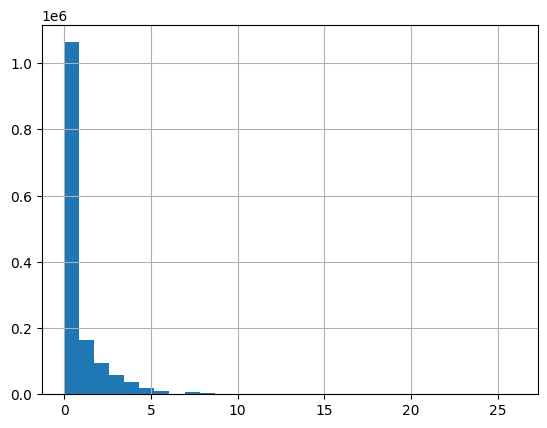

In [ ]:
df._500us_distinct_tickers.hist(bins=30)

<Axes: >

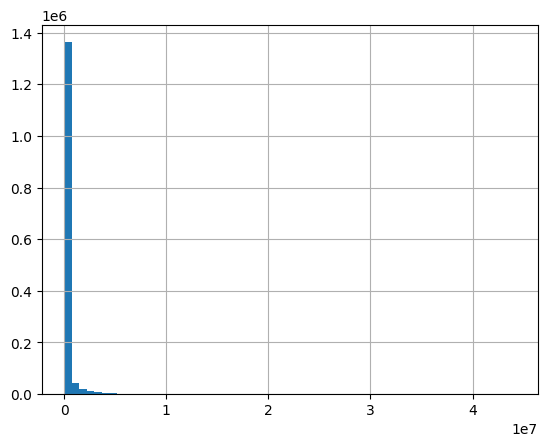

In [ ]:
df._500us_notional.hist(bins=60)

In [ ]:
QUANTILE = 0.95
col_name = "_500us_distinct_tickers"
col_name_clip = col_name + "_clip"


In [ ]:
df[col_name_clip] = df[col_name].clip(upper=df[col_name].quantile(QUANTILE))

In [ ]:
grouped_df = df[['hit_ratio', 'pnl_to_close', col_name_clip]].groupby(by=col_name_clip).agg(ppt_mean=("pnl_to_close","mean"),ppt_std=("pnl_to_close","std"), hit_ratio=("hit_ratio","mean"))

In [ ]:
df.columns

Index(['time', 'event', 'order_id', 'size', 'price', 'direction',
       'ask_price_1', 'bid_price_1', 'ticker', 'mid', '_250us_neighbors',
       '_500us_neighbors', '_250us_distinct_tickers_ss_bf',
       '_250us_distinct_tickers_ss_af', '_250us_distinct_tickers_os_bf',
       '_250us_distinct_tickers_os_af', '_250us_notional_ss_bf',
       '_250us_notional_ss_af', '_250us_notional_os_bf',
       '_250us_notional_os_af', '_250us_num_trades_ss_bf',
       '_250us_num_trades_ss_af', '_250us_num_trades_os_bf',
       '_250us_num_trades_os_af', '_500us_distinct_tickers_ss_bf',
       '_500us_distinct_tickers_ss_af', '_500us_distinct_tickers_os_bf',
       '_500us_distinct_tickers_os_af', '_500us_notional_ss_bf',
       '_500us_notional_ss_af', '_500us_notional_os_bf',
       '_500us_notional_os_af', '_500us_num_trades_ss_bf',
       '_500us_num_trades_ss_af', '_500us_num_trades_os_bf',
       '_500us_num_trades_os_af', 'pnl_to_close', 'hit_ratio',
       '_500us_distinct_tickers', '_500u

In [ ]:
grouped_df

,ppt_mean,ppt_std,hit_raio
_500us_distinct_tickers_clip,,,
0,-0.620705,62.241559,0.492495
1,-1.154729,60.229855,0.488880
2,-0.983373,59.119667,0.490208
3,-1.211530,61.456763,0.483649
4,0.284174,60.475169,0.499092


In [ ]:
grouped_df = df[['hit_ratio', 'pnl_to_close', col_name_clip]].groupby(by=col_name_clip).agg(ppt_mean=("pnl_to_close","mean"),ppt_std=("pnl_to_close","std"), hit_ratio=("hit_ratio","mean"))

In [ ]:
QUANTILE = 0.95
col_name = "_500us_num_trades"
col_name_clip = col_name + "_clip"

In [ ]:
df[col_name_clip] = df[col_name].clip(upper=df[col_name].quantile(QUANTILE))

In [ ]:
grouped_df = df[['hit_ratio', 'pnl_to_close', col_name_clip]].groupby(by=col_name_clip).agg(ppt_mean=("pnl_to_close","mean"),ppt_std=("pnl_to_close","std"), hit_ratio=("hit_ratio","mean"))

In [ ]:
grouped_df

,ppt_mean,ppt_std,hit_ratio
_500us_num_trades_clip,,,
0,-0.620705,62.241559,0.492495
1,-0.951186,59.917935,0.490033
2,-0.552256,59.514261,0.496018
3,-0.552811,59.919713,0.492704
4,-1.243655,60.074425,0.485892
5,-0.166191,58.707417,0.499487
6,-0.618547,59.863505,0.488867
7,-0.146460,60.773337,0.501561
8,-0.332109,61.497333,0.477329


<Axes: xlabel='_500us_distinct_tickers_clip'>

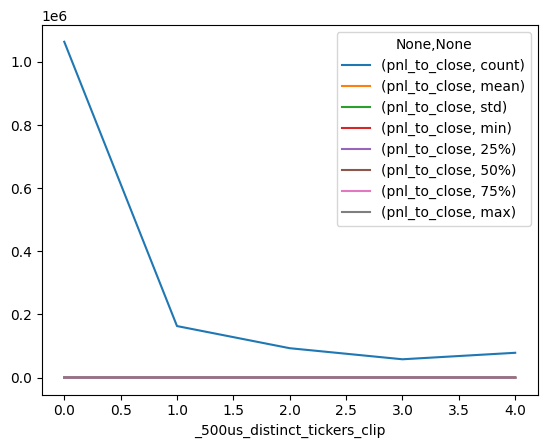

In [ ]:
grouped_df.plot()

In [ ]:
df

,time,event,order_id,size,price,direction,ask_price_1,bid_price_1,ticker,mid,...,_500us_notional_os_af,_500us_num_trades_ss_bf,_500us_num_trades_ss_af,_500us_num_trades_os_bf,_500us_num_trades_os_af,pnl_to_close,hit_ratio,_500us_distinct_tickers,_500us_num_trades,_500us_distinct_tickers_clip
datetime,,,,,,,,,,,,,,,,,,,,,
2021-01-04 09:30:01.095900732,34201.095901,5,0,100,67.775,1,67.79,67.60,XLC,67.695,...,0.0,0,0,0,0,-211.729989,False,0,0,0
2021-01-04 09:30:02.675304503,34202.675305,4,33616440,20,67.790,-1,67.79,67.70,XLC,67.745,...,0.0,0,0,0,0,213.895855,True,0,0,0
2021-01-04 09:30:02.675304503,34202.675305,4,33721376,100,67.790,-1,67.84,67.70,XLC,67.770,...,0.0,0,0,0,0,213.895855,True,0,0,0
2021-01-04 09:30:10.075087808,34210.075088,5,0,100,67.770,1,67.81,67.76,XLC,67.785,...,0.0,0,0,0,0,-211.007821,False,0,0,0
2021-01-04 09:30:10.093825097,34210.093825,4,34697420,100,67.760,1,67.84,67.70,XLC,67.770,...,0.0,0,0,0,0,-209.563164,False,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 15:59:59.045476854,57599.045477,4,591568780,100,77.680,-1,77.69,77.67,XLC,77.680,...,0.0,0,5,0,0,-0.000000,False,1,5,1
2021-12-31 15:59:59.529061656,57599.529062,4,591025012,700,77.690,-1,77.69,77.68,XLC,77.685,...,0.0,0,1,0,0,1.287167,True,1,1,1
2021-12-31 15:59:59.529061656,57599.529062,4,591032188,100,77.690,-1,77.69,77.68,XLC,77.685,...,0.0,0,1,0,0,1.287167,True,1,1,1


In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()